# Neighbour2Neighbor Experiment

[CVPR 2021: Neighbor2Neighbor: Self-Supervised Denoising from Single Noisy Images](https://openaccess.thecvf.com/content/CVPR2021/papers/Huang_Neighbor2Neighbor_Self-Supervised_Denoising_From_Single_Noisy_Images_CVPR_2021_paper.pdf)

Key idea: 
- By utilizing a random neighbor subsampler on a single noisy image, we can generate two pairs of noisy images that share a similar clean reference, addressing certain limitations of the noise2noise approach.
- To compensate for discrepancies between the true pixel values of the subsampled noisy images, an extra regularization term is incorporated into the loss function.

limitation:
- The intrinsic similarity among neighboring pixels might not be robust enough to ensure effective denoising, particularly when considering spatial correlations. This could potentially diminish the performance of the Nb2Nb (Neighbor to Neighbor) approach.

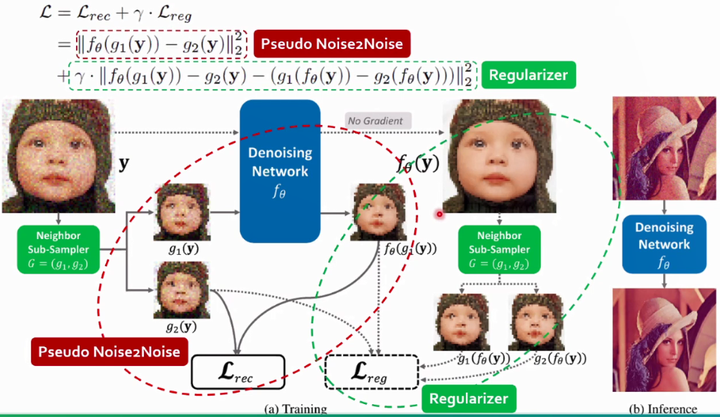

In [ ]:
import os
import copy
import json
import time

import numpy as np
import matplotlib.pyplot as plt

from module.utils import calculate_metrics, display_image_in_detail, plot_2d_data, timer_decorator, display_4d_image, timer_decorator
from module.datasets import load_4d_dicom, save_4d_dicom, restore_data, split_data

from module.models import UNet2D
from module.datasets import Nb2Nb2D_Dataset
from module.loss import SSIMLoss, SSIM_MAELoss, SSIM_MSELoss



import h5py
from tqdm.notebook import tqdm


import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset

from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"device: {device}")

# 0. Load preprocessed data

In [ ]:
# load noisy data
with h5py.File('./dataset/preprocessed/PT_20p 150_120 OSEM_gaussian_0.50_batch.h5', 'r') as f:
    noisy_data = f['dataset'][...]
    restore_info = json.loads(f['restore_info'][()])
    
print(f"Noisy data...{noisy_data.dtype} (shape:{noisy_data.shape}; range:[{np.min(noisy_data)},{np.max(noisy_data)}]; mean:{np.mean(noisy_data)}); std:{np.std(noisy_data)}")

print(restore_info)

display_image_in_detail(noisy_data[0, 11, 38], title="prepared noisy data")

# 1. Create Nb2NbDataset with random neighbor subsampler

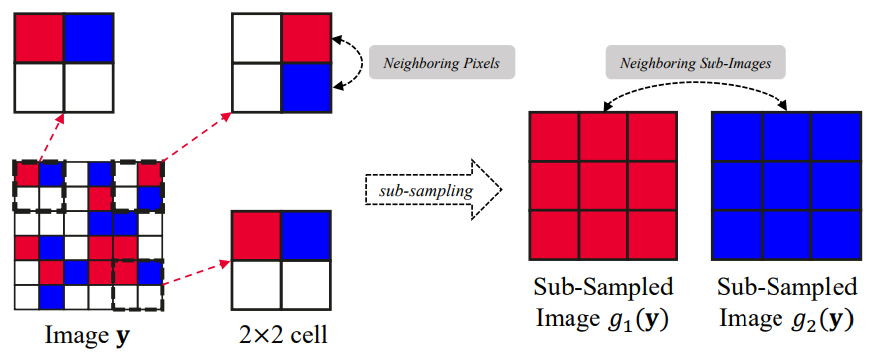

In [ ]:
## split ndarray data
train_data, val_data, test_data = split_data(noisy_data)

## add channel dim
train_tensor = torch.tensor(train_data[..., np.newaxis, :, :, :], dtype=torch.float32) 
val_tensor = torch.tensor(val_data[..., np.newaxis, :, :, :], dtype=torch.float32) 
test_tensor = torch.tensor(test_data[..., np.newaxis, :, :, :], dtype=torch.float32) 

print(f"train_tensor:\n {train_tensor.dtype}; shape:{train_tensor.shape}; range:({torch.min(train_tensor)},{torch.max(train_tensor)}); mean:{torch.mean(train_tensor)}; std:{torch.std(train_tensor)}")
print(f"val_tensor:\n {val_tensor.dtype}; shape:{val_tensor.shape}; range:({torch.min(val_tensor)},{torch.max(val_tensor)}); mean:{torch.mean(val_tensor)}; std:{torch.std(val_tensor)}")
print(f"test_tensor:\n {test_tensor.dtype}; shape:{test_tensor.shape}; range:({torch.min(test_tensor)},{torch.max(test_tensor)}); mean:{torch.mean(test_tensor)}; std:{torch.std(test_tensor)}")


# create Nb2Nb dataset 
train_dataset = Nb2Nb2D_Dataset(train_tensor, k=2)
val_dataset = Nb2Nb2D_Dataset(val_tensor, k=2)
test_dataset = Nb2Nb2D_Dataset(test_tensor, k=2)

print(f"train_dataset: {len(train_dataset)}")
print(f"val_dataset: {len(val_dataset)}")
print(f"test_dataset: {len(test_dataset)}")


# create dataloader
batch_size = 16
num_workers = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
# example batch plot
num_batches_to_display = 3  # for example, show 3 batches

# Iterate through the DataLoader
for batch_idx, (slice_2d, g1, g2) in enumerate(train_loader):
    
    # Print data details
    print(f"Batch {batch_idx + 1}")
    print(f"slice_2d: {slice_2d.dtype} {slice_2d.shape} range:({torch.max(slice_2d)},{torch.min(slice_2d)}); mean:{torch.mean(slice_2d)}; std:{torch.std(slice_2d)}")
    print(f"g1: {g1.dtype} {g1.shape} range:({torch.max(g1)},{torch.min(g1)}); mean:{torch.mean(g1)}; std:{torch.std(g1)}")
    print(f"g2: {g2.dtype} {g2.shape} range:({torch.max(g2)},{torch.min(g2)}); mean:{torch.mean(g2)}; std:{torch.std(g2)}")

    # select the show baych index
    idx = -1

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    axes[0].imshow(slice_2d[idx].permute(2, 1, 0), cmap='hot')
    axes[0].set_title('Noisy Img')

    axes[1].imshow(g1[idx].permute(2, 1, 0), cmap='hot')
    axes[1].set_title('First downsampled')

    axes[2].imshow(g2[idx].permute(2, 1, 0), cmap='hot')
    axes[2].set_title('Second downsampled')


    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    
    # Break loop after displaying desired number of batches
    if batch_idx + 1 == num_batches_to_display:
        break

# 2. Define loss function with reguralization term

In [ ]:
# def random_neighbor_subsample(tensor, k=2):
#         """
#         Perform random neighbor sub-sampling on a tensor of shape CxHxW.
        
#         Args:
#         - tensor (torch.Tensor): Input tensor of shape CxHxW.
#         - k (int): Size of the cell for sub-sampling.
        
#         Returns:
#         - g1, g2 (torch.Tensor, torch.Tensor): Two sub-sampled tensors, each of shape Cx(H//k)x(W//k).
#         """
#         # Check tensor dimensions
#         C, H, W = tensor.shape
        
#         # Initialize sub-sampled tensors
#         g1 = torch.zeros((C, H//k, W//k))
#         g2 = torch.zeros((C, H//k, W//k))
        
#         for i in range(0, H, k):
#             for j in range(0, W, k):
#                 # Randomly select one of the kxk neighbors for g1 and another for g2
#                 neighbors = [(i+x, j+y) for x in range(k) for y in range(k)]
#                 idx1, idx2 = torch.randperm(k*k)[:2]  # Randomly select two indices
#                 g1[:, i//k, j//k] = tensor[:, neighbors[idx1][0], neighbors[idx1][1]]
#                 g2[:, i//k, j//k] = tensor[:, neighbors[idx2][0], neighbors[idx2][1]]
        
#         return g1, g2


# def random_neighbor_subsample(tensor, k=2):
#     """
#     Perform random neighbor sub-sampling on a batch tensor of shape BxCxHxW.
#     """
#     # Check tensor dimensions
#     B, C, H, W = tensor.shape
    
#     # Initialize sub-sampled tensors
#     g1 = torch.zeros((B, C, H//k, W//k))
#     g2 = torch.zeros((B, C, H//k, W//k))
    
#     for b in range(B):
#         for i in range(0, H, k):
#             for j in range(0, W, k):
#                 # Randomly select one of the kxk neighbors for g1 and another for g2
#                 neighbors = [(i+x, j+y) for x in range(k) for y in range(k)]
#                 idx1, idx2 = torch.randperm(k*k)[:2]  # Randomly select two indices
#                 g1[b, :, i//k, j//k] = tensor[b, :, neighbors[idx1][0], neighbors[idx1][1]]
#                 g2[b, :, i//k, j//k] = tensor[b, :, neighbors[idx2][0], neighbors[idx2][1]]
    
#     return g1, g2




# def joint_loss_function(model, device, criterion, g1_output, g2, original_noisy_image, gamma=1.0):
#     """
#     Neighbor2Neighbor loss function with reconstruction and regularization terms.
    
#     Args:
#         - model ： the network
#         - devoce : device
#         - criterion: reconstruction loss
#         - g1_output (tensor): the first sub-sampled image from the random neighbor sub-sampler.
#         - g2 (tensor): the second sub-sampled image from the random neighbor sub-sampler.
#         - original_noisy_image (tensor): the original noisy image before input network
#         - gamma (float, optional): weight for the regularization term. Defaults to 1.0 for real-world noisy image, 2.0 for systhetic.
        
#     Return:
#         - joint_loss(float): joint loss func with regularization term 
#     """
#     g1_output = g1_output.to(device)
#     g2 = g2.to(device)
#     original_noisy_image = original_noisy_image.to(device)
    
#     # reconstruction loss : similar to typical loss function
#     reconstuction_loss = criterion(g1_output, g2)
    
#     # regularization loss
#     with torch.no_grad():
#         no_grad_noisy_pred = model(original_noisy_image)
        
#     no_grad_g1_output, no_grad_g2_output = random_neighbor_subsample(no_grad_noisy_pred, k=2)
#     no_grad_g1_output = no_grad_g1_output.to(device)
#     no_grad_g2_output = no_grad_g2_output.to(device)
    
#     regularization_loss = (g1_output - g2 - (no_grad_g1_output - no_grad_g2_output)).norm(p=2, dim=(1,2,3)).mean()
    
#     joint_loss = reconstuction_loss + gamma * regularization_loss
    
#     return joint_loss

def random_neighbor_subsample(tensor, k=2):
    B, C, H, W = tensor.shape
    unfolded = tensor.unfold(2, k, k).unfold(3, k, k)
    unfolded = unfolded.contiguous().view(B, C, H//k, W//k, k*k)
    
    idx1, idx2 = torch.randperm(k*k)[:2].to(tensor.device)
    
    g1 = unfolded[..., idx1].squeeze(-1)
    g2 = unfolded[..., idx2].squeeze(-1)
    
    return g1, g2


def joint_loss_function(model, device, criterion, g1_output, g2, original_noisy_image, gamma=1.0):
    g1_output = g1_output.to(device)
    g2 = g2.to(device)
    
    # reconstruction loss
    reconstuction_loss = criterion(g1_output, g2)
    
    # regularization loss
    with torch.no_grad():
        no_grad_noisy_pred = model(original_noisy_image)
        no_grad_g1_output, no_grad_g2_output = random_neighbor_subsample(no_grad_noisy_pred, k=2)

    regularization_loss = (g1_output - g2 - (no_grad_g1_output - no_grad_g2_output)).norm(p=2, dim=(1,2,3)).mean()
    
    joint_loss = reconstuction_loss + gamma * regularization_loss
    
    return joint_loss

    

# 3. Define model and other training modules

In [ ]:
model = UNet2D(in_channels=1, out_channels=1).to(device)

print("The number of parameters of the network is: ",  sum(p.numel() for p in model.parameters() if p.requires_grad))
#summary(model, [(1, 192, 192)])
summary(model, [(1, 96, 96)])

In [ ]:
def train(model, train_loader, criterion, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    pbar = tqdm(train_loader, desc="Training", dynamic_ncols=True)
    for slice_2d, g1, g2 in pbar:
        
        slice_2d, g1, g2 = slice_2d.to(device), g1.to(device), g2.to(device)
        
        # Forward
        g1_output = model(g1)
        
        # Zero the gradient buffers
        optimizer.zero_grad()
        
        loss = joint_loss_function(model, device, criterion, g1_output, g2, slice_2d)
        
        # Backward
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix({"batch_loss": loss.item()})
    
    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    return avg_loss



def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0 
    pbar = tqdm(val_loader, desc="Validating", dynamic_ncols=True)
    with torch.no_grad():
        for slice_2d, g1, g2 in pbar:
            
            slice_2d, g1, g2 = slice_2d.to(device), g1.to(device), g2.to(device)
            
            g1_output = model(g1)
            
            loss = joint_loss_function(model, device, criterion, g1_output, g2, slice_2d)
            
            total_loss += loss.item()
            pbar.set_postfix({"batch_loss": loss.item()})
    
    avg_loss = total_loss / len(val_loader)
    
    return avg_loss



def test(model, test_loader, device, dataset):
    model.eval()
    p, t, d = dataset.p, dataset.t, dataset.d
    # Note: d represents number of continuous slices after subtracting 2
    original_shape = (p, t, dataset.data_tensor.shape[2], d+2, dataset.data_tensor.shape[4], dataset.data_tensor.shape[5])

    preds = torch.zeros(original_shape).to(device)
    targets = torch.zeros(original_shape).to(device)

    pbar = tqdm(test_loader, desc="Testing", dynamic_ncols=True)
    with torch.no_grad():
        for idx, (slice_2d, _) in enumerate(pbar):
            
            slice_2d = slice_2d.to(device)
            
            batch_preds = model(slice_2d)

            for b_idx, pred in enumerate(batch_preds):
                pred = pred.squeeze(0) # [channels, height, width]
                true_idx = idx*test_loader.batch_size + b_idx
                patience_idx = true_idx // (t * d)
                time_idx = (true_idx % (t * d)) // d
                depth_idx = true_idx % d + 1
                
                preds[patience_idx, time_idx, :, depth_idx, :, :] = pred
                targets[patience_idx, time_idx, :, depth_idx, :, :] = slice_2d[b_idx]

    return preds.cpu(), targets.cpu()


@timer_decorator
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=50, patience=5, save_path='path/to/your/directory'):
    best_loss = float('inf')
    early_stopping_counter = 0
    best_epoch = -1
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, scheduler, device)
        val_loss = validate(model, val_loader, criterion, device)
        
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.8f}, Validation Loss: {val_loss:.8f}, LR: {current_lr:.8e}")

        # Save the model with the best validation loss
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1  # 1-based counting for epoch
            best_save_path = os.path.join(save_path, f'best_model.pth')
            torch.save(best_model_wts, best_save_path)
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping after {patience} epochs without improvement epoch:{epoch - patience}.")
                break

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# investigate performance with pytorch profiler 
import torch.profiler


def train(model, train_loader, criterion, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    pbar = tqdm(train_loader, desc="Training", dynamic_ncols=True)
    
    with torch.profiler.profile(
        schedule=torch.profiler.schedule(wait=2, warmup=2, active=6),
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./log_dir'),
        record_shapes=True,
        profile_memory=True,
        with_stack=True
    ) as prof:
        for slice_2d, g1, g2 in pbar:
            slice_2d, g1, g2 = slice_2d.to(device), g1.to(device), g2.to(device)

            # Forward
            g1_output = model(g1)

            # Zero the gradient buffers
            optimizer.zero_grad()

            loss = joint_loss_function(model, device, criterion, g1_output, g2, slice_2d)

            # Backward
            loss.backward()

            # Update weights
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix({"batch_loss": loss.item()})
            
            prof.step()  # Don't forget this to ensure the profiler steps forward
        
    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    return avg_loss


In [ ]:
import time

def train(model, train_loader, criterion, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    
    start_time = time.time()
    pbar = tqdm(train_loader, desc="Training", dynamic_ncols=True)
    print("Time for tqdm initialization:", time.time() - start_time)
    
    for slice_2d, g1, g2 in pbar:
        start_time = time.time()
        slice_2d, g1, g2 = slice_2d.to(device), g1.to(device), g2.to(device)
        print("Time for data to device:", time.time() - start_time)

        start_time = time.time()
        g1_output = model(g1)
        print("Time for forward pass:", time.time() - start_time)

        start_time = time.time()
        optimizer.zero_grad()
        print("Time for zeroing gradients:", time.time() - start_time)

        start_time = time.time()
        loss = joint_loss_function(model, device, criterion, g1_output, g2, slice_2d)
        print("Time for computing loss:", time.time() - start_time)

        start_time = time.time()
        loss.backward()
        print("Time for backward pass:", time.time() - start_time)

        start_time = time.time()
        optimizer.step()
        print("Time for optimizer step:", time.time() - start_time)

        total_loss += loss.item()
        pbar.set_postfix({"batch_loss": loss.item()})

    start_time = time.time()
    scheduler.step()
    print("Time for scheduler step:", time.time() - start_time)

    avg_loss = total_loss / len(train_loader)
    return avg_loss


In [ ]:
# define loss, optimizer, lr_scheduler

criterion = nn.L1Loss()
#criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# 4. Process training

In [ ]:
%load_ext line_profiler

In [ ]:
%lprun -f train train(model, train_loader, criterion, optimizer, scheduler, device)

In [ ]:
trained_model = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=200, patience=10, save_path="./check_points")

# 5. Evaluation

In [ ]:
# load best model
model.load_state_dict(torch.load('check_points/best_model.pth'))

In [ ]:
preds, targets = test(model, test_loader, device, test_dataset)

In [ ]:
denoised_data = preds[0].squeeze(1).numpy()
true_data = targets[0].squeeze(1).numpy()

print(f"denoised data: {denoised_data.dtype}; shape:{denoised_data.shape}; range:({np.min(denoised_data)},{np.max(denoised_data)}); mean:{np.mean(denoised_data)}; std:{np.std(denoised_data)}")
print(f"true_data data: {true_data.dtype}; shape:{true_data.shape}; range:({np.min(true_data)},{np.max(true_data)}); mean:{np.mean(true_data)}; std:{np.std(true_data)}")


# example plot
data_range_true = np.max(true_data[11, 38]) - np.min(true_data[11, 38])
data_range_denoised = np.max(denoised_data[11, 38]) - np.min(denoised_data[11, 38])
data_range = max(data_range_true, data_range_denoised)
print(f"data range: {data_range}")
psnr_values, ssim_values, mae_values, brisque_values = calculate_metrics(denoised_data[11, 38], true_data[11, 38], data_range=data_range)
print(f"PSNR: {np.nanmean(psnr_values)}; SSIM: {np.nanmean(ssim_values)}; MAE: {np.sum(mae_values)}; BRISQUE: {np.mean(brisque_values)}")

display_image_in_detail(denoised_data[11, 38], title='denoised')
display_image_in_detail(true_data[11, 38], title='true')

In [ ]:
data_range_true = np.max(true_data) - np.min(true_data)
data_range_denoised = np.max(denoised_data) - np.min(denoised_data)
data_range = max(data_range_true, data_range_denoised)
print(f"data range: {data_range}")

#
psnr_values, ssim_values, mae_values, brisque_values = calculate_metrics(denoised_data, true_data, data_range=data_range)

psnr_values[np.isinf(psnr_values)] = np.nan # set inf value to nan

print(f"PSNR: {np.nanmean(psnr_values)}; SSIM: {np.nanmean(ssim_values)}; MAE: {np.sum(mae_values)}; BRISQUE: {np.nanmean(brisque_values)}")

# Save denormalized denoised data into 16-bit DICOM files

In [ ]:
# denormalized denoised data
restored_data = restore_data(denoised_data, restore_info)
print(f"restore_data: {restored_data.dtype} shape:{restored_data.shape}; range:({np.min(restored_data)},{np.max(restored_data)}); mean:{np.mean(restored_data)}; std:{np.std(restored_data)}")
display_image_in_detail(restored_data[11, 38], title="restored")

In [ ]:
# save denormalized denoised data as 16-bit gray-scale .DICOM files
origin_dicom_folder = './dataset/10_05_2021_PET_only/PT_20p 150_120 OSEM'

output_folder = './dataset/denoised/N2V/PT_20p 150_120 OSEM_gaussian_0.50'

save_4d_dicom(origin_dicom_folder, restored_data, output_folder)